# Week 12 — Visualization for ML / NLP (2)
includes a **2,000‑review IMDB subset** (via Hugging Face)

pip install wordcloud  
pip install jupyter_compare_view  
pip install datasets umap-learn hdbscan bertopic sentence-transformers

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

## NLP on IMDB (2k subset): Load, Train, Visualize

### 1) Load IMDB (Hugging Face) and take small, balanced subsets

In [3]:
from datasets import load_dataset

imdb = load_dataset('imdb')
small_train = imdb['train'].shuffle(seed=42).select(range(2000))
small_test  = imdb['test'].shuffle(seed=42).select(range(1000))
train_df = pd.DataFrame(small_train)
test_df  = pd.DataFrame(small_test)
train_df.head()

,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0


### 1) Word clouds

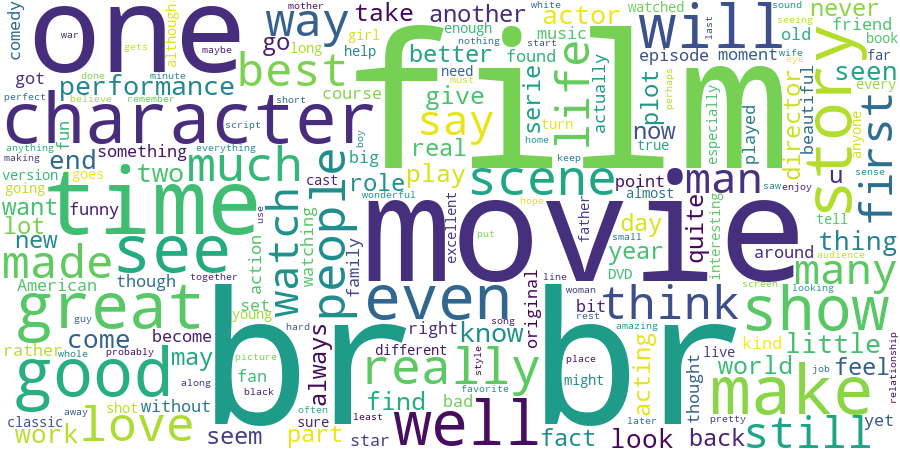

In [4]:
from wordcloud import WordCloud
pos_text = ' '.join(train_df[train_df.label==1].text)
neg_text = ' '.join(train_df[train_df.label==0].text)
wc1 = WordCloud(width=900, height=450, background_color='white').generate(pos_text).to_image()
wc1

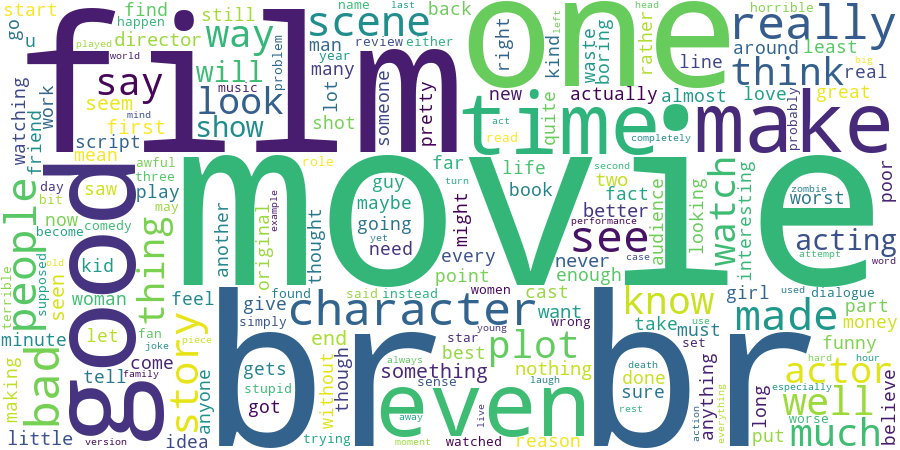

In [5]:
wc2 = WordCloud(width=900, height=450, background_color='white').generate(neg_text).to_image()
wc2

Jupyter compare_view v0.2.4



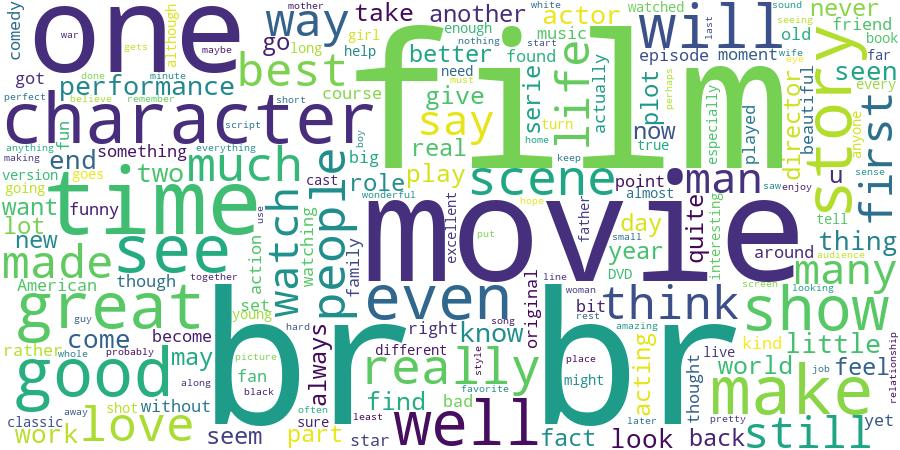
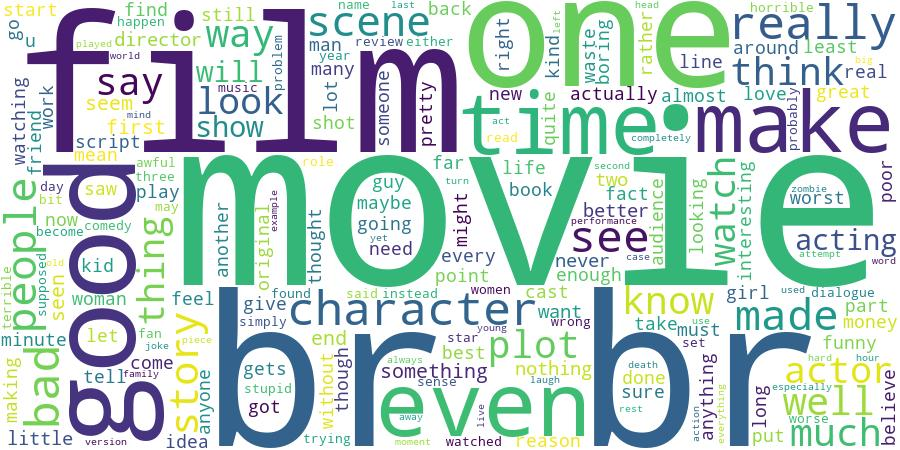

In [6]:
from jupyter_compare_view import compare
from PIL import Image
import numpy as np

img1 = wc1
img2 = wc2

compare(img1, img2, cmap="gray", start_mode="horizontal", start_slider_pos=0.5, height=500, add_controls=False)

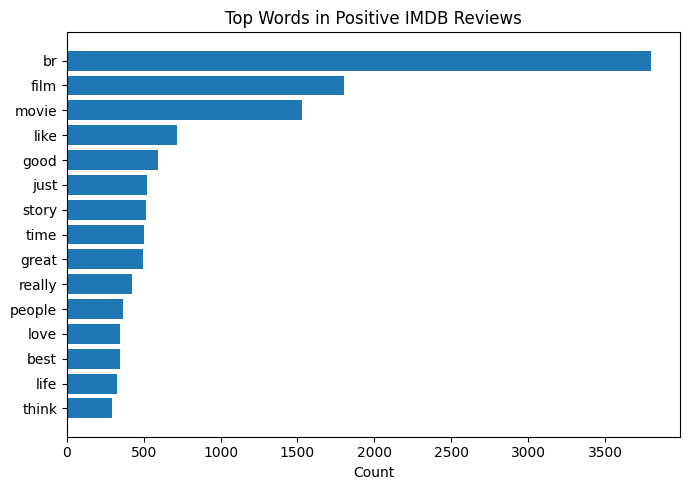

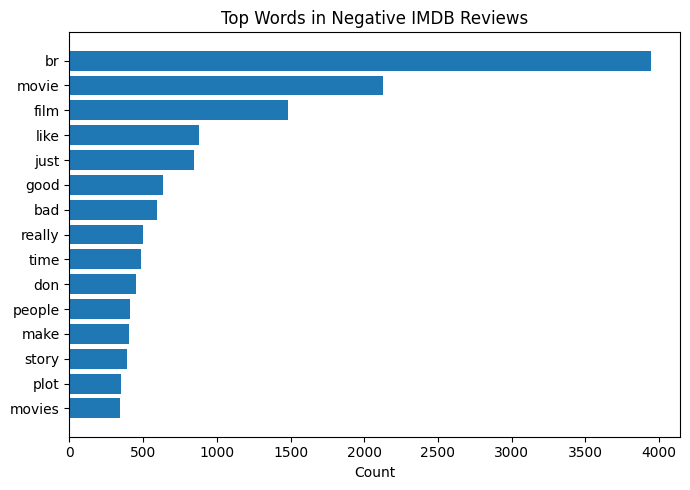

In [7]:
# If needed:
# %pip install datasets

from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# 1. Load a subset of IMDB for speed
imdb = load_dataset("imdb")
train = imdb["train"].shuffle(seed=42).select(range(2000))   # 2k reviews

df = pd.DataFrame(train)   # columns: 'text', 'label' (0=neg, 1=pos)

# 2. Split positive / negative reviews
pos_docs = df[df["label"] == 1]["text"].tolist()
neg_docs = df[df["label"] == 0]["text"].tolist()

# 3. Build a CountVectorizer with English stopwords removed
vectorizer = CountVectorizer(stop_words="english", max_features=5000)

# Fit on ALL documents so vocabulary is shared
vectorizer.fit(df["text"])

# Transform positive and negative separately
X_pos = vectorizer.transform(pos_docs)
X_neg = vectorizer.transform(neg_docs)

vocab = vectorizer.get_feature_names_out()

# 4. Get top N words per class
import numpy as np

def top_words(X, vocab, top_n=15):
    counts = np.array(X.sum(axis=0)).ravel()
    idx = counts.argsort()[::-1][:top_n]
    return vocab[idx], counts[idx]

pos_words, pos_counts = top_words(X_pos, vocab, top_n=15)
neg_words, neg_counts = top_words(X_neg, vocab, top_n=15)

# 5. Plot positive words
plt.figure(figsize=(7,5))
plt.barh(pos_words[::-1], pos_counts[::-1])
plt.title("Top Words in Positive IMDB Reviews")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 6. Plot negative words
plt.figure(figsize=(7,5))
plt.barh(neg_words[::-1], neg_counts[::-1])
plt.title("Top Words in Negative IMDB Reviews")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


### 2) Topic-like clusters (TF‑IDF + KMeans + 2D projection)

C:\Users\JJ\anaconda3\envs\dataviz\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


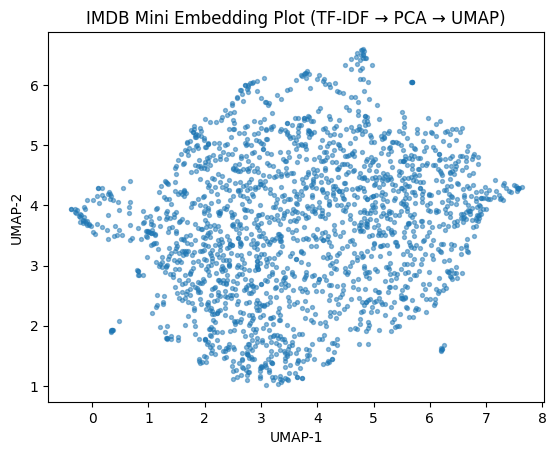

In [ ]:
# %pip install datasets umap-learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap.umap_ as umap

# 1. Load IMDB subset
docs = train_df["text"]

# 2. TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(docs)

# 3. PCA → 50 dimensions
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# 4. UMAP → 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_2d = reducer.fit_transform(X_pca)

# 5. Plot
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=8, alpha=0.5)
plt.title("IMDB Mini Embedding Plot (TF-IDF → PCA → UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


Batches: 100%|██████████| 63/63 [00:04<00:00, 12.86it/s]


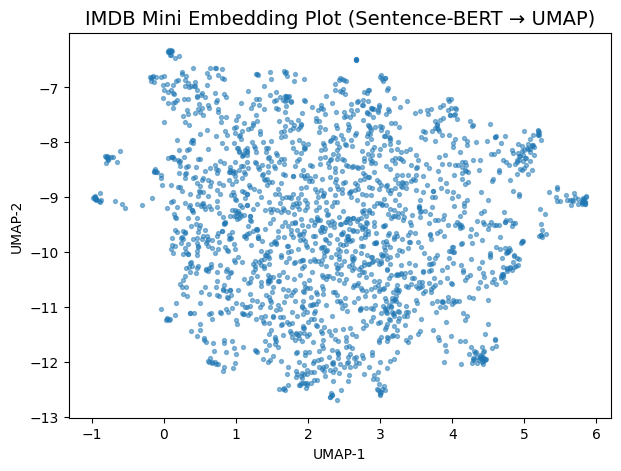

In [ ]:
from sentence_transformers import SentenceTransformer

# 1. Load IMDB subset
docs = train_df["text"]

# 2. Sentence-BERT embedding (384-dim embeddings)
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs, show_progress_bar=True)

# 3. UMAP → 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_2d = reducer.fit_transform(embeddings)

# 4. Plot
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=8, alpha=0.5)
plt.title("IMDB Mini Embedding Plot (Sentence-BERT → UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [9]:
# If running locally, you may need to install these:
# %pip install datasets umap-learn hdbscan bertopic sentence-transformers

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.grid"] = False


In [10]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,   # cap vocabulary size
    min_df=5             # ignore very rare words
)

X = vectorizer.fit_transform(docs)
X.shape


(2000, 5000)

In [11]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X.toarray())
X_pca.shape

(2000, 50)

C:\Users\JJ\anaconda3\envs\dataviz\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


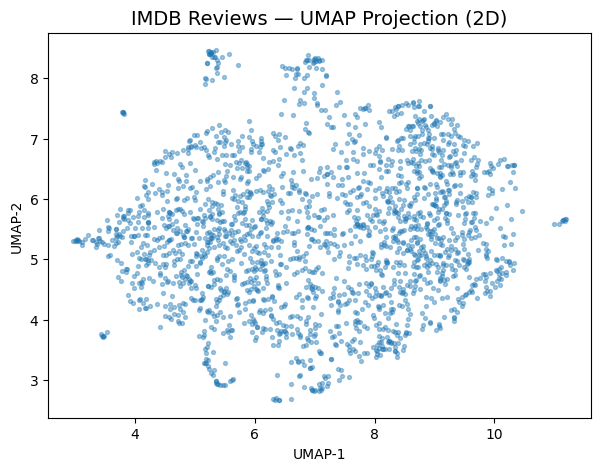

In [12]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    metric="euclidean"
)

X_2d = reducer.fit_transform(X_pca)

plt.scatter(X_2d[:, 0], X_2d[:, 1], s=8, alpha=0.4)
plt.title("IMDB Reviews — UMAP Projection (2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [14]:
def plot_clusters(X_2d, labels, title):
    unique = np.unique(labels)
    plt.figure(figsize=(7, 5))
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                        s=8, alpha=0.4, c="lightgray", label="noise (-1)")
        else:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=8, alpha=0.7, label=f"cluster {lab}")
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()

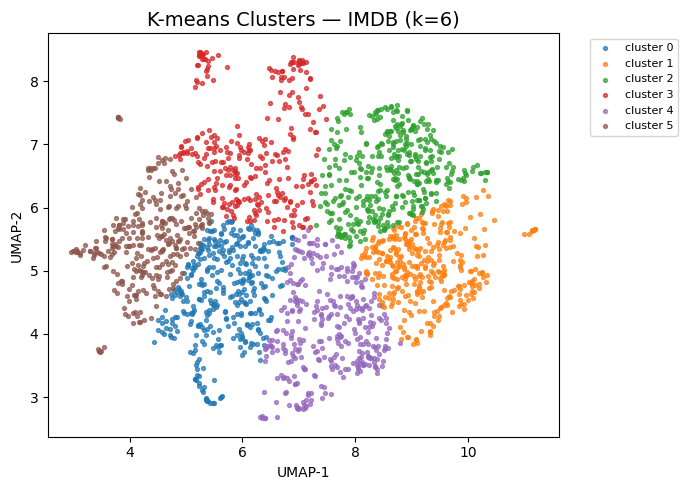

In [15]:
kmeans = KMeans(n_clusters=6, random_state=42)
labels_km = kmeans.fit_predict(X_2d)

plot_clusters(X_2d, labels_km, "K-means Clusters — IMDB (k=6)")


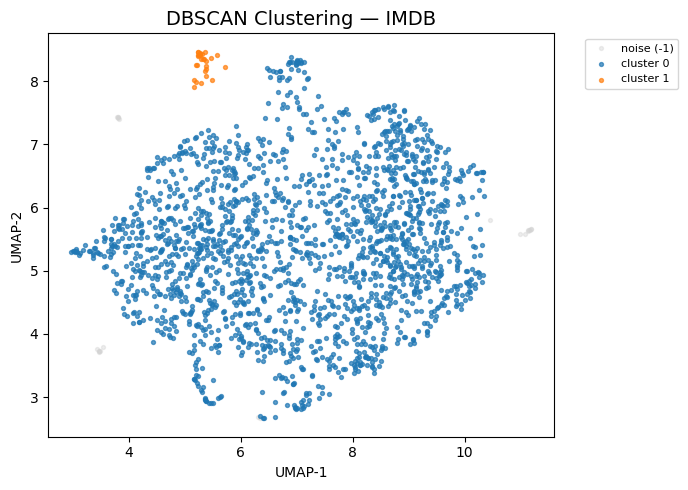

In [16]:
dbscan = DBSCAN(eps=0.35, min_samples=10).fit(X_2d)
labels_db = dbscan.labels_

plot_clusters(X_2d, labels_db, "DBSCAN Clustering — IMDB")


C:\Users\JJ\anaconda3\envs\dataviz\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\JJ\anaconda3\envs\dataviz\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


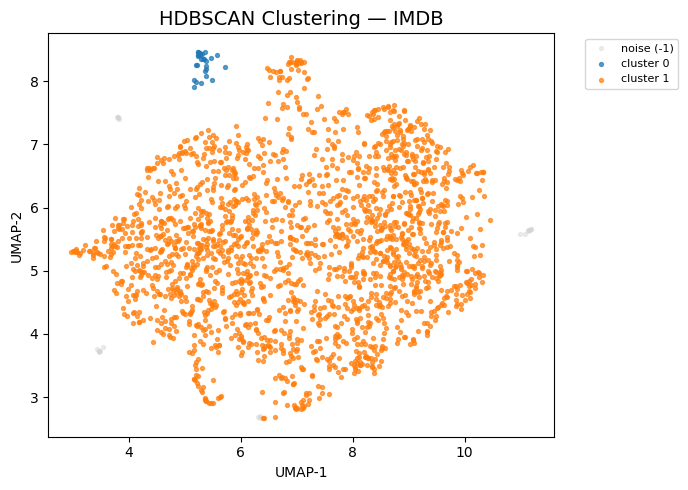

In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
labels_hdb = clusterer.fit_predict(X_2d)

plot_clusters(X_2d, labels_hdb, "HDBSCAN Clustering — IMDB")


In [18]:
cluster_id = 0  # change this to inspect different clusters

idx = np.where(labels_hdb == cluster_id)[0][:5]  # first 5 docs in this cluster
for i in idx:
    print(f"--- Review {i} (cluster {cluster_id}) ---")
    print(docs[i][:400], "\n")


--- Review 2 (cluster 0) ---
George P. Cosmatos' "Rambo: First Blood Part II" is pure wish-fulfillment. The United States clearly didn't win the war in Vietnam. They caused damage to this country beyond the imaginable and this movie continues the fairy story of the oh-so innocent soldiers. The only bad guys were the leaders of the nation, who made this war happen. The character of Rambo is perfect to notice this. He is extrem 

--- Review 219 (cluster 0) ---
When the US entered World War I, the government forced Hollywood to churn out propaganda films. THE LITTLE American is probably the best of the lot because it stars Mary Pickford.<br /><br />Pickford plays a young woman torn between two men: Jack Holt (German) and Raymond Hatton (French), but her decision is delayed because of the war as both men enlist.<br /><br />When the ship Pickford is sailin 

--- Review 258 (cluster 0) ---
I stumbled across this (Act-I) by pure dumb luck and this was more than a decade ago. This was'nt even 

In [19]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
# Use a smaller subset (e.g., 2000 docs) for speed
docs_bertopic = list(train_df["text"])  # already 2000 above; adjust if you want fewer
len(docs_bertopic)

2000

In [21]:
vectorizer_model = CountVectorizer(
    stop_words="english",      # remove stopwords
    ngram_range=(1,2),         # optional: capture bigrams
    min_df=10                  # optional: ignore very rare words
)

topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs_bertopic)

In [ ]:
# You can customize the embedding model
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)

topics, probs = topic_model.fit_transform(docs_bertopic)

len(set(topics)), topics[:10]


2025-11-18 04:44:07,540 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 63/63 [00:04<00:00, 14.83it/s]
2025-11-18 04:44:13,060 - BERTopic - Embedding - Completed ✓
2025-11-18 04:44:13,061 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 04:44:14,763 - BERTopic - Dimensionality - Completed ✓
2025-11-18 04:44:14,764 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 04:44:14,796 - BERTopic - Cluster - Completed ✓
2025-11-18 04:44:14,797 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 04:44:14,902 - BERTopic - Representation - Completed ✓


(30, [-1, 1, 3, -1, 2, 3, 12, -1, -1, -1])

In [22]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1004,-1_br_film_movie_like,"[br, film, movie, like, just, good, really, ti...","[I think that my favorite part of this movie, ..."
1,0,88,0_br_movie_role_love,"[br, movie, role, love, film, young, just, mot...","[WRITTEN ON THE WIND, directed by Douglas Sirk..."
2,1,77,1_movie_worst_bad_film,"[movie, worst, bad, film, br, seen, money, jus...",[STUDIO 666 (aka THE POSSESSED in the UK) is a...
3,2,76,2_series_episode_shows_br,"[series, episode, shows, br, like, tv, charact...",[The Sopranos is probably the most widely accl...
4,3,70,3_war_br_film_story,"[war, br, film, story, world, movie, american,...","[10 out of 10, this brilliant, super documenta..."
5,4,66,4_music_film_musical_dance,"[music, film, musical, dance, song, br, movie,...","[Okay... it seems like so far, only the Barman..."
6,5,60,5_horror_movie_film_scary,"[horror, movie, film, scary, br, story, good, ...",[Satan's Little Helper is one of the better B ...
7,6,57,6_movie_br_film_like,"[movie, br, film, like, time, scenes, characte...","[Hitokiri (which translates roughly as ""assass..."
8,7,49,7_killer_film_br_murder,"[killer, film, br, murder, movie, kill, scene,...",[*** out of ****<br /><br />Yep! Dressed To Ki...
9,8,44,8_sex_film_gay_scenes,"[sex, film, gay, scenes, br, movie, woman, lik...",[first this deserves about 5 stars due to acti...


In [23]:
fig = topic_model.visualize_barchart(top_n_topics=10)
fig


In [24]:
fig = topic_model.visualize_topics()
fig


In [25]:
fig = topic_model.visualize_hierarchy()
fig